## Пожары в Москве.

Задание:

В архиве (во вложении) датасет по домам в Москве с признаком: был или нет пожар в этом доме (последний столбец). Столбцы обезличены, но для некоторых есть возможность понять смысл, исходя из значений.

Необходимо обучить оптимальную модель, выделить наиболее значимые признаки. Решение с комментариями и выводами следует представить в виде питоновского ноутбука.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scipy.stats as ss
import scipy as sp
from statsmodels.sandbox.stats.multicomp import multipletests 
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline

Загрузим данные и для удобства переименуем названия столбцов: Numerical_* - для вещественных признаков, Categorical_* - для категориальных признаков.

In [2]:
# Создаем обработчик времен
parser = lambda x: pd.to_datetime(x, format='%d.%m.%Y %H:%M:%S', errors='coerce')
#parser = lambda x: pd.tseries.tools.to_datetime(x, format='%d/%m/%Y', errors='coerce')

In [3]:
data = pd.read_csv(r"C:\Users\ilya.Volchkov\Downloads\fires_data_20170602.csv", sep=";", encoding='cp1251', dtype={'col_30': pd.datetime},\
                   parse_dates=['col_'+str(i) for i in [4,6,26,30]],\
                   date_parser = parser)
data.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_95,col_96,col_97,col_98,col_99,col_100,col_101,col_102,col_103,is_fire
0,2,0,1,674,2005-03-31,2206862,2005-04-07,1,317,1,...,0,0.0,1,55.878091,37.716252,0.0,0.0,0.0,14437.0,0
1,2,0,1,2034,2006-08-15,2211394,2006-08-25,1,317,1,...,0,0.0,7,55.879106,37.714483,0.0,0.0,0.0,14437.0,0
2,2,0,1,1933-р,2002-05-27,1001232,2002-06-04,1,107,1,...,0,5.0,20,55.737263,37.672810,0.0,0.0,0.0,14437.0,0
3,2,0,1,2436,2005-10-06,2208688,2005-10-31,1,306,1,...,0,0.0,52,55.906744,37.571525,0.0,0.0,0.0,0.0,0
4,2,0,1,6701-p,2003-11-18,1005304,2003-11-28,1,101,1,...,0,0.0,55,55.747388,37.598151,0.0,0.0,0.0,14437.0,0


Посмотрим на общее описание данных.

In [4]:
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161955 entries, 0 to 161954
Data columns (total 105 columns):
col_0      161955 non-null int64
col_1      161955 non-null int64
col_2      161955 non-null int64
col_3      161955 non-null object
col_4      139587 non-null datetime64[ns]
col_5      161955 non-null int64
col_6      139179 non-null datetime64[ns]
col_7      161955 non-null int64
col_8      161955 non-null int64
col_9      161955 non-null int64
col_10     161955 non-null float64
col_11     161955 non-null float64
col_12     161955 non-null float64
col_13     161955 non-null float64
col_14     161955 non-null float64
col_15     161955 non-null float64
col_16     161955 non-null float64
col_17     161955 non-null float64
col_18     161955 non-null float64
col_19     161955 non-null float64
col_20     161955 non-null float64
col_21     161955 non-null float64
col_22     161955 non-null float64
col_23     161955 non-null int64
col_24     161955 non-null int64
col_25     161955 

Имеется 4 столбца, в которых хранятся временные данные, в 1 столбце - строковые значения, а в остальных - числовые значения.
Пропуски есть только во временных данных, в соответствующих 4 столбцах.

In [5]:
data.describe()

,col_0,col_1,col_2,col_5,col_7,col_8,col_9,col_10,col_11,col_12,...,col_95,col_96,col_97,col_98,col_99,col_100,col_101,col_102,col_103,is_fire
count,161955.000000,161955.000000,161955.000000,1.619550e+05,161955.000000,161955.000000,161955.000000,161955.000000,161955.000000,161955.000000,...,161955.000000,161955.000000,1.619550e+05,161955.000000,161955.000000,1.619550e+05,161955.000000,161955.000000,161955.000000,161955.000000
mean,1.989386,0.021364,1.579389,4.384665e+06,1.656405,538.661394,0.951227,4.878472,0.420185,5.909463,...,0.795400,4.159841,3.160799e+04,14.987572,10.229587,5.794065e+04,0.010157,0.265629,22165.725702,0.087074
std,0.102477,0.144595,3.765649,3.286060e+06,0.474909,313.262020,0.216423,32.532907,1.938725,24.981643,...,8.350259,15.814281,2.585844e+05,24.714929,16.933289,4.053265e+05,0.274466,0.981536,11633.724807,0.281944
min,1.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000,1.019648e+06,1.000000,303.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,14437.000000,0.000000
50%,2.000000,0.000000,1.000000,4.009053e+06,2.000000,509.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,23979.000000,0.000000
75%,2.000000,0.000000,1.000000,7.106094e+06,2.000000,809.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,3.367500e+03,55.588206,37.360924,0.000000e+00,0.000000,0.000000,29884.000000,0.000000
max,2.000000,1.000000,39.000000,9.305030e+07,2.000000,1210.000000,2.000000,1110.000000,19.000000,123.000000,...,1054.000000,598.000000,4.500004e+06,56.011032,55.943487,5.007628e+06,46.000000,22.000000,36204.000000,1.000000


Видим, что в некоторых числовых столбцах преобладает какое-то конкретное значение, возможно они являются категориальными или порядковыми признаками. Ниже посмотрим на число различных значений в каждом столбце, чтобы проверить это. Такая информация будет полезна при построении линейных классификаторов, например, для логистической регрессии. Для случайного леса или градиентного бустинга над решающими деревьями данная информация не столько полезна, в силу использования деревьев.

In [6]:
data.describe(include=['object', 'datetime64'])

,col_3,col_4,col_6,col_26,col_30
count,161955,139587,139179,161070,126
unique,23480,4161,4030,5158,53
top,0,2003-11-03 00:00:00,2004-11-24 00:00:00,2012-12-25 00:00:00,2011-06-29 00:00:00
freq,22369,2568,1026,1306,15
first,NaN,1900-07-18 00:00:00,1998-02-23 00:00:00,1900-07-30 00:00:00,1998-06-22 00:00:00
last,NaN,2016-11-10 00:00:00,2016-11-11 00:00:00,2016-10-13 00:00:00,2014-04-02 00:00:00


В col_3, col_4, col_6 наиболее часто встречаются нули (пропущенные значения), такого рода объектов встречается около 13 %. В col_30 встречается подавляющее число нулей (пропущенных значений), возможно ненулевые значения соответствуют имеено положительному классу. А вот у col_26 есть почти все значения.

Посмотрим на число уникальных значений у каждого признака.

In [7]:
for col in data.columns:
    print("{} number of unique values: {}".format(col, data[col].nunique()))

col_0 number of unique values: 2
col_1 number of unique values: 2
col_2 number of unique values: 24
col_3 number of unique values: 23480
col_4 number of unique values: 4161
col_5 number of unique values: 137178
col_6 number of unique values: 4030
col_7 number of unique values: 2
col_8 number of unique values: 147
col_9 number of unique values: 3
col_10 number of unique values: 514
col_11 number of unique values: 19
col_12 number of unique values: 17
col_13 number of unique values: 239
col_14 number of unique values: 143
col_15 number of unique values: 50
col_16 number of unique values: 17
col_17 number of unique values: 73
col_18 number of unique values: 25
col_19 number of unique values: 161
col_20 number of unique values: 97
col_21 number of unique values: 97
col_22 number of unique values: 159096
col_23 number of unique values: 10
col_24 number of unique values: 1486
col_25 number of unique values: 30
col_26 number of unique values: 5158
col_27 number of unique values: 2
col_28 numb

Отсюда видим, что имеются числовые признаки с малым числом уникальных значений (меньше 15-20). Скорее всего они являются либо категориальными, либо порядковыми признаками. Причем многие признаки принимают какое-то значение для большинства объектов выборки (более 75%), например, col_0, col_1, col_7, col_9 и другие. Для примера ниже рассматрвиается признак col_1. 

In [8]:
data.col_1.value_counts()

0    158495
1      3460
Name: col_1, dtype: int64

В тоже время, имеются признаки, которые почти на каждом объекте принимают уникальное значение: col_5, col_22.

Рассчитаем доли классов `пожар` и `не пожар`.

In [9]:
print("Доля пожар: %lf" % (data[data.is_fire == 1].shape[0]/data.shape[0]))
print("Доля не пожар: %lf" % (data[data.is_fire == 0].shape[0]/data.shape[0]))

Доля пожар: 0.087074
Доля не пожар: 0.912926


Как мы видим доля не пожара преобладает над пожаром, на который приходится приблизительно 9 %. Таким образом, классы несбалансированны в выборке.

In [10]:
num_features = data.select_dtypes(include=[np.number]).columns[:-1]
cat_features = data.select_dtypes(exclude=[np.number]).columns

In [11]:
# Выделяем временные признаки и один строковый признак.
date_features = ["col_"+str(i) for i in [4,6,26,30]]
abbr_feature = "col_3"

In [12]:
# Будем рассматривать признаки с малым числом уникальных значений как категориальные.
cat_features = ["col_"+str(i) for i in [0,1,7,9,27,28,29,31,34,39,40,62,63,65,76,77,79,80,81,82,94]]

In [13]:
# Оставшиеся признаки - числовые
num_features = [feat for feat in ["col_"+str(i) for i in range(104)]\
                if feat not in ([abbr_feature] + date_features + cat_features)]

In [14]:
from itertools import product, combinations

### Числовые признаки

Рассчитаем корреляцию Пирсона между числовыми признаками. При этом, у многих признаков имеется подавляющее число нулей, с одной стороны, это может быть свидетельством пропусков в данных, например, данный признак не определен для данного типа здания, либо признак в действитеольности равен 0. Из-за этого имеется две возможности: включать нули при расчете коэффициента корреляции Пирсона или рассматривать только ненулевые значения. Так как данные анонимизированы рассмотрим оба случая.

In [15]:
for num_feat1, num_feat2 in combinations(num_features, 2):
    corr, p_val = ss.pearsonr(data[num_feat1], data[num_feat2])
    if(abs(corr) > 0.8):
        print(num_feat1, num_feat2, corr)

col_10 col_13 0.974963021173
col_11 col_12 0.915852084722
col_15 col_16 0.899994799781
col_15 col_18 0.934784381495
col_16 col_18 0.805843186372
col_20 col_21 0.956433793363
col_22 col_98 -0.821341644848
col_22 col_99 -0.809404313123
col_24 col_98 0.905506295897
col_24 col_99 0.901981859165
col_35 col_75 0.976796966469
col_35 col_83 0.997925314463
col_42 col_43 0.941804973929
col_45 col_50 0.815103216373
col_45 col_51 0.801244839635
col_45 col_52 0.816149268785
col_46 col_50 0.803874571574
col_46 col_52 0.803014219814
col_50 col_51 0.977284492539
col_50 col_52 0.992854227527
col_50 col_67 0.911488531972
col_50 col_68 0.928792522597
col_50 col_78 0.820994059571
col_50 col_84 0.924184126718
col_50 col_88 0.835797789511
col_50 col_89 0.920228228283
col_50 col_90 0.914889038969
col_50 col_91 0.900247150385
col_50 col_92 0.867258985867
col_50 col_93 0.813868511911
col_51 col_52 0.984674659467
col_51 col_67 0.937318976107
col_51 col_68 0.884236016556
col_51 col_72 0.816351803149
col_51 col_7

In [16]:
for num_feat1, num_feat2 in combinations(num_features, 2):
    test = data[(data[num_feat1].values != 0) & (data[num_feat2].values != 0)][[num_feat1, num_feat2]]
    if test.shape[0] < 1:
        continue
    corr, p_val = ss.pearsonr(test[num_feat1], test[num_feat2])
    if(abs(corr) > 0.8):
        print(num_feat1, num_feat2, corr)

C:\Users\ilya.Volchkov\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\ilya.Volchkov\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


col_5 col_64 0.957764315209
col_10 col_13 0.95779913831
col_15 col_16 0.822689059026
col_15 col_18 0.880170553116
col_20 col_21 0.815152526554
col_22 col_64 0.843896916909
col_22 col_97 1.0
col_22 col_100 1.0
col_23 col_100 0.826403873794
col_24 col_100 -0.908843454168
col_35 col_75 0.978568416361
col_35 col_83 0.998268462543
col_41 col_55 0.834025594157
col_41 col_56 0.88643464532
col_42 col_43 0.920137391506
col_45 col_46 0.866389361602
col_45 col_47 0.917446535649
col_45 col_78 0.854773732121
col_46 col_47 0.812140081586
col_46 col_73 0.836169434584
col_47 col_50 0.82273512869
col_47 col_51 0.804624837733
col_47 col_52 0.824362957391
col_47 col_56 0.825054980589
col_47 col_78 0.878962717193
col_47 col_89 0.801960142192
col_49 col_50 0.882023384179
col_49 col_51 0.867174500609
col_49 col_52 0.874597977727
col_49 col_55 0.852337209923
col_49 col_56 0.904016944968
col_49 col_73 0.894343264884
col_49 col_84 0.801261181441
col_49 col_89 0.821561881859
col_49 col_90 0.803234111775
col_49 

Как мы видим, коэффициент корреляции для col_22, col_97, col_100 при таком рассмотрении равна 1. Посмотрим на значения этих признаков.

In [17]:
# Некоторые признаки полностью совпадают при определенных условиях.
num_feat1, num_feat2 = 'col_22', 'col_100'
test = data[(data[num_feat1].values != 0) & (data[num_feat2].values != 0)][[num_feat1, num_feat2]]
test.head()

,col_22,col_100
5,64.0,64.0
11,93.0,93.0
18,156.0,156.0
20,165.0,165.0
22,223.0,223.0


In [18]:
# Различие только в 3 элементах.
test.shape, (data.col_100 != 0).values.sum(), (data.col_22 != 0).values.sum()

((14099, 2), 14102, 161106)

У col_2 почти все значения ненулевые, но при этом на тех объектах, где col_100 не равно нуля, они совпадают. Интересно посмотреть на распределение col_22, возможно на тех элементах, для которых col_100 равно нулю, col_22 принимает значения близкие к нулю.

In [19]:
num_feat1, num_feat2 = 'col_97', 'col_100'
test = data[(data[num_feat1].values != 0) & (data[num_feat2].values != 0)][[num_feat1, num_feat2]]
test.head()

,col_97,col_100
5,64,64.0
11,93,93.0
18,156,156.0
20,165,165.0
22,223,223.0


In [20]:
test.shape, (data.col_100 != 0).values.sum(), (data.col_97 != 0).values.sum()

((10836, 2), 14102, 43545)

In [21]:
num_feat1, num_feat2 = 'col_97', 'col_22'
test = data[(data[num_feat1].values != 0) & (data[num_feat2].values != 0)][[num_feat1, num_feat2]]
test.head()

,col_97,col_22
0,1,1.0
1,7,7.0
2,20,20.0
3,52,52.0
4,55,55.0


In [22]:
test.shape, (data.col_97 != 0).values.sum(), (data.col_22 != 0).values.sum()

((43545, 2), 43545, 161106)

Аналогичная ситуация, что для col_22 и col_100.

Видим, что имеется достаточно много пар признаков с большим коэффициентом корреляции, что говорит о почти линейной зависимости между ними, а некоторые в точности совпадают для ненулевых значений. Следует оставить только один признак из такой пары, чтобы не столкнуться с проблемой мультиколлинеарности.

Кандидаты на удаление: 10, 11, 15, 22, 20, 35, 42, 50, 51, 52, 53, 55, 59, 67, 68, 75, 84, 86, 88, 89, 90, 91, 98.

In [23]:
excluded_num_features = ["col_"+str(i) for i in [10, 11, 16, 20, 35, 42, 50, 51, 52, 53,\
                                                              55, 59, 67, 68, 75, 84, 86, 88, 89, 90, 91, 98]]
num_features = [feat for feat in num_features if feat not in excluded_num_features]

Рассчитаем корреляции числовых переменных с целевой функцией.

Целевая функция предсталвляет собой бинарную переменную. Теоретически мы можем рассчитать корреляцию Пирсона между непрерывной переменной и целевой функцией, но сложно будет проанализировать полученные таким образом результаты, так как корреляция Пирсона не рассчитана на такое применение.

В качестве критерия зависимости между случайными величинами одна из которых вещественно-значная,а другая бинарная, будем использовать разность математических ожиданий $X_1\in \mathbb{R}^n$, $X_2 \in \{0, 1\}$.
\begin{equation}
E(X_1\vert X_2 = 1) - E(X_1\vert X_2 = 0)
\end{equation}

Для корректного сравнения корреляции с целевой переменной разных признаков нам потребуется привести их к одному масштабу.

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
scaler = StandardScaler()
data_num = pd.DataFrame(scaler.fit_transform(data[num_features]), columns=num_features)
data_num.head()

,col_2,col_5,col_8,col_12,col_13,col_14,col_15,col_17,col_18,col_19,...,col_92,col_93,col_95,col_96,col_97,col_99,col_100,col_101,col_102,col_103
0,-0.153862,-0.662742,-0.707593,-0.236553,-0.153938,-0.155628,-0.127372,-0.166181,-0.139109,-0.051111,...,-0.317056,-0.293568,-0.095255,-0.263044,-0.122231,1.623238,-0.142949,-0.037007,-0.270627,-0.664340
1,-0.153862,-0.661363,-0.707593,-0.236553,-0.153938,-0.155628,-0.127372,-0.166181,-0.139109,0.237669,...,0.242196,0.651859,-0.095255,-0.263044,-0.122208,1.623133,-0.142949,-0.037007,-0.270627,-0.664340
2,-0.153862,-1.029635,-1.377961,4.406871,1.898303,-0.155628,2.602536,1.321009,4.924817,0.959621,...,0.571167,1.360929,-0.095255,0.053127,-0.122158,1.620672,-0.142949,-0.037007,-0.270627,-0.664340
3,-0.153862,-0.662186,-0.742708,-0.236553,-0.153938,-0.155628,-0.127372,-0.166181,-0.139109,-0.195502,...,-0.317056,-0.293568,-0.095255,-0.263044,-0.122034,1.614691,-0.142949,-0.037007,-0.270627,-1.905305
4,-0.153862,-1.028396,-1.397114,4.406871,1.299733,-0.155628,1.237582,11.460943,3.236842,0.526450,...,-0.086776,-0.057211,-0.095255,-0.263044,-0.122022,1.616263,-0.142949,-0.037007,-0.270627,-0.664340


Далее находим корреляции вещественных признаков с целеваой переменной.

In [26]:
def find_mean(data, num_feature, bin_val):
    return data[data['is_fire'] == bin_val][num_feature].mean()

def find_correlation(data, num_feature):
    return (find_mean(data, num_feature, bin_val= 1) - find_mean(data, num_feature, bin_val= 0))

In [27]:
num_corr = []
val_dict = {}
data_num['is_fire'] = data.is_fire
for idx, num_feature in enumerate(num_features):
    val_dict[idx] = num_feature
    num_corr.append(find_correlation(data_num, num_feature))
num_corr = np.array(num_corr)

In [28]:
corr = np.abs(num_corr)

Рассмотрим топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных постром:
* Распределения в разрезе классов
* Отобразите объекты в координатах пар признаков

In [29]:
top20 = corr.argsort()[-1:-21:-1]
top20_feat = []
for val in top20:
    print("%s corr: %lf" % (val_dict[val], num_corr[val]))
    top20_feat.append(val_dict[val])

col_100 corr: 1.641699
col_92 corr: 1.579814
col_93 corr: 1.498333
col_45 corr: 1.482037
col_46 corr: 1.453763
col_83 corr: 1.424851
col_78 corr: 1.383376
col_21 corr: 1.319259
col_85 corr: 1.283364
col_102 corr: 1.276009
col_99 corr: 1.208119
col_66 corr: 1.206366
col_72 corr: 1.204744
col_49 corr: 1.137795
col_24 corr: 1.125635
col_95 corr: 1.093958
col_73 corr: 1.091624
col_22 corr: -1.089728
col_87 corr: 0.935519
col_47 corr: 0.900052


Имеются признаки как положительно коррелированные с целевой переменной, так и отрицательно коррелированные.

Распределение в разрезе классов.

Используем два метода: гистограммы и ядерные функции. Зеленым отмечен отток, а синим не отток.

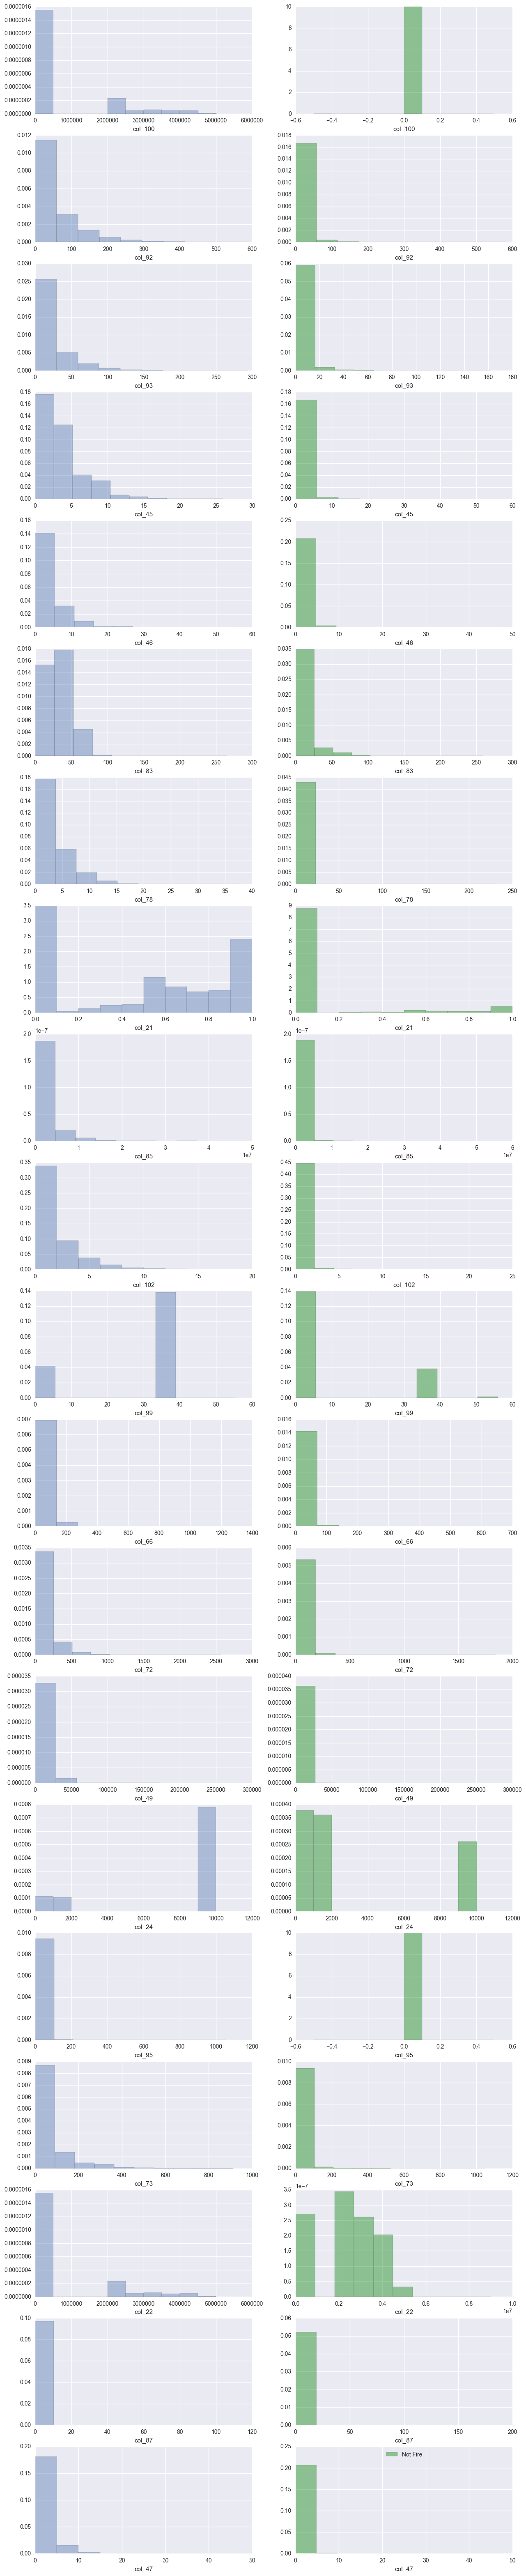

In [31]:
fig, ax = plt.subplots(nrows=20, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(80)
for i in range(20):
    sns.distplot(data[data.is_fire == 1][val_dict[top20[i]]].dropna(), bins=10, ax=ax[i,0],\
                 norm_hist=True, kde=False, label="Fire")
    sns.distplot(data[data.is_fire == 0][val_dict[top20[i]]].dropna(), bins=10, ax=ax[i,1],\
                 norm_hist=True, kde=False, color='g', label="Not Fire")

plt.show()

C:\Users\ilya.Volchkov\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\ilya.Volchkov\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


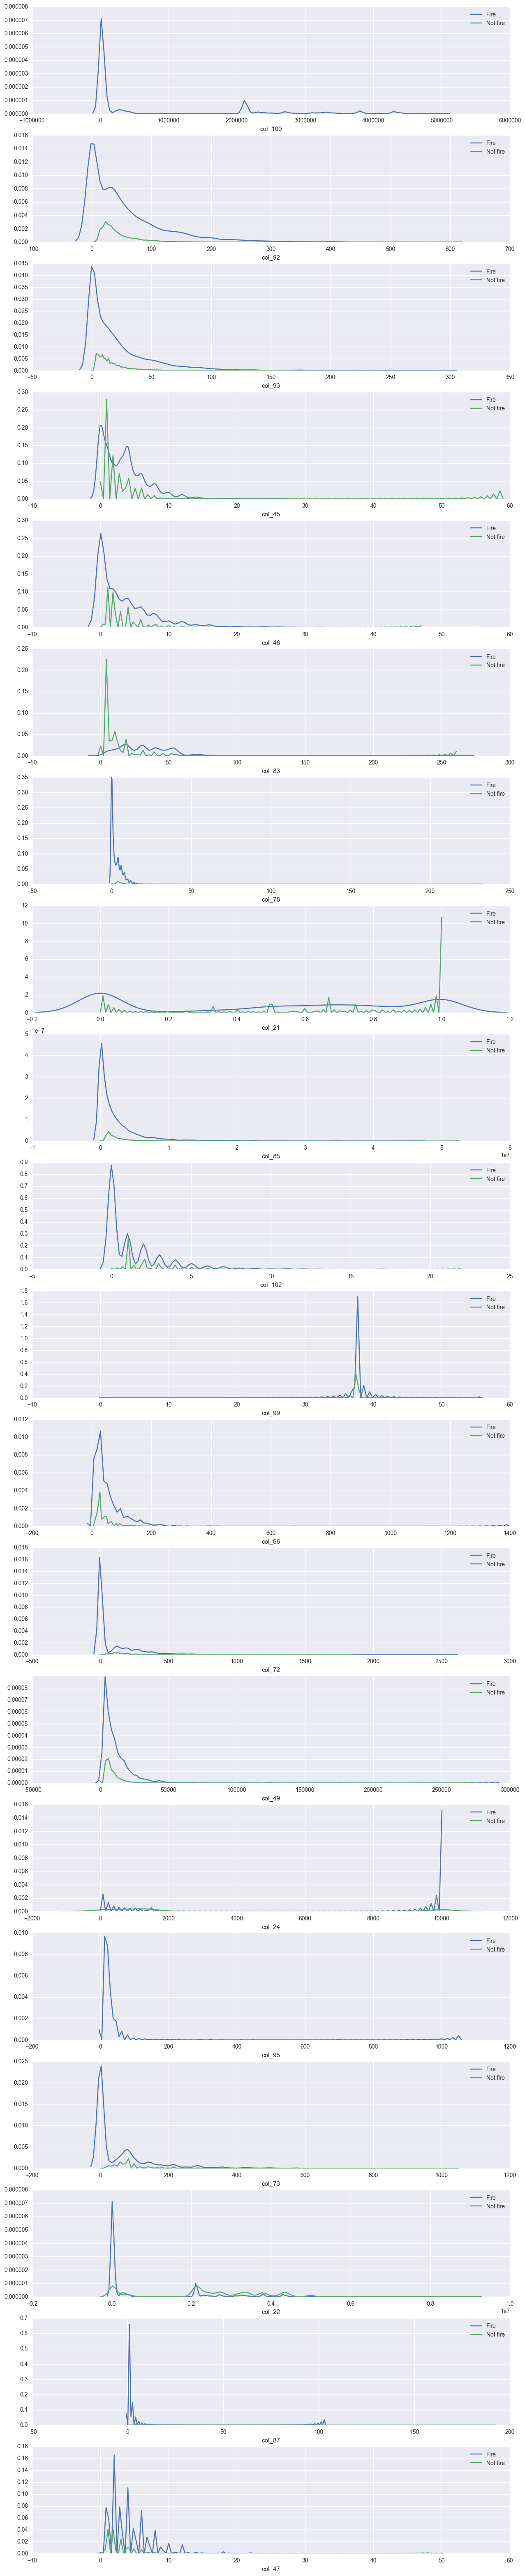

In [32]:
fig, ax = plt.subplots(nrows=20, ncols=1)
fig.set_figwidth(15)
fig.set_figheight(80)
for i in range(20):
    п(data[data['is_fire'] == 1][val_dict[top20[i]]], ax=ax[i], norm_hist=True, hist=False, label='Fire')
    sns.distplot(data[data['is_fire'] == 0][val_dict[top20[i]]], ax=ax[i], norm_hist=True, hist=False, label='Not fire')
plt.show()

Проблемы возникли при восстановлении плотности для признака col_100, ниже мы его подробнее рассмотрим.

Видно, что объекты "не пожар" чаще принимают нулевые значения, а не пожар, наоборот, ненулевые значения. Это говорит о том, что данные признаки полезны для выделения класса "пожар".

Отобразим классы в координатах пар признаков. Для этого воспользуемся методом pairplot из пакета seaborn. Синим отмечен отток, а зеленым - не отток.

In [33]:
plt.figure(figsize=(15,15))
sns.pairplot(data, vars=top20_feat, hue='is_fire')
plt.show()

KeyboardInterrupt: 

Наблюдается разделение по паре col_100, col_22, данные признаки будут полезны при построении классификатора, но вспомним также о том, что когда оба эти признаки не равны нулю, то они в точности совпадают.

Применим критерий Манна-Уитни для првоерки гипотезы о том, что распределения в разрезе классов не различаются. Сделаем потом поправку на множественную проверку гипотез. Конечно, выборка большая и скорее всего нулевая гипотеза будет отвергнута в пользу альтернативы.

In [ ]:
p_vals = []
for i, feat in enumerate(num_features):
    target_0 = data.loc[data.is_fire == 0, feat]
    target_1 = data.loc[data.is_fire == 1, feat]
    if len(target_0) < 10 or len(target_1) < 10:
        p_val = 1
    else:
        p_val = ss.mannwhitneyu(target_0, target_1)[1]
    p_vals.append(p_val)

Сделаем поправку на множественную првоерку гипотез, для этого воспользуемся методом Хольма.

In [ ]:
p_val_list = multipletests(p_vals, method='holm')
p_val_df = pd.DataFrame(p_val_list[1], index = num_features, columns = ['p-value']).sort_values('p-value', ascending=False)
p_val_df.head()

Только по двум признакам не была отвергнута нулевая гипотеза: col_44, col_36. Возможно они являются шумовыми.

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(121)
sns.distplot(data[data.is_fire == 0].col_44, axlabel='col_44: Not fire')
plt.subplot(122)
sns.distplot(data[data.is_fire == 1].col_44, axlabel='col_44: Fire');

Для col_44 распределения в разрезе классов действительно почти совпадают. У col_36 распределение в разрезе классов также схожи.

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
sns.distplot(data[data.is_fire == 0].col_36, ax=ax, label="Not fire")
sns.distplot(data[data.is_fire == 1].col_36, ax=ax, label='Fire')
ax.legend();

У многих признаков количество нулевых значений преобладет над ненулевыми: нулевых более 75%. Например, к таким относится col_100, который уже рассматривался выше в паре с признаками col_22 и col_97.

In [ ]:
data['col_100'].value_counts()

У этого признака огромное число нулей. Посмотрим соотношение классов при равенстве данного признака нулю.

In [ ]:
data[data.col_100 == 0].is_fire.mean()

Последнее говорит о том, что если данный признак равен нулю, то класс в точности "не пожар". Посмотрим на соотношение классов при неравенстве данного признака нулю.

In [34]:
data[data.col_100 != 0].is_fire.mean()

1.0

In [36]:
data.is_fire.unique()

array([0, 1], dtype=int64)

In [41]:
data[data.col_100!=0].is_fire.unique()

array([1], dtype=int64)

А это говорит о том, что если col_100 больше нуля, тогда класс объекта - "пожар". Таким образом, по данному признаку мы можем со 100% точностью разделить выборку.

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
pred = list(map(int,(data.col_100.values != 0)))
accuracy_score(data.is_fire, pred)

col_100 полностью "компроментирует" класс объекта. А вспоминая о связи col_100 с col_97 и col_22, возможно, что таковыми являются и 2 последних признака, правда, в меньшей степени, так как у них много ненулевых значений.

Несмотря на это, продолжим анализ признаков.

Проделаем аналогичные шаги для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной.

In [ ]:
bot10_feat = []
bot10 = corr.argsort()[0:10:1]
for val in bot10:
    print("%s corr: %lf" % (val_dict[val], num_corr[val]))
    bot10_feat.append(val_dict[val])

Получили признаки, которые имеют почти нулевую корреляцию с целевой переменной.

Изобразим распределения с помощью гистограмм, в этом случае их будет достаточно, так как мы видим, что распределения в разрезе классов практически не различаются.

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(40)
for i in range(10):
    sns.distplot(data[data['is_fire'] == 1][val_dict[bot10[i]]].dropna(), bins=10, ax=ax[i,0],\
                 norm_hist=True, kde=True, hist=False, label="Fire")
    sns.distplot(data[data['is_fire'] == 0][val_dict[bot10[i]]].dropna(), bins=10, ax=ax[i,1],\
                 norm_hist=True, kde=True, hist=False, color='g', label="Not fire")
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(40)
for i in range(10):
    sns.distplot(data[data['is_fire'] == 1][val_dict[bot10[i]]].dropna(), bins=10, ax=ax[i,0],\
                 norm_hist=True, kde=False,label="Fire")
    sns.distplot(data[data['is_fire'] == 0][val_dict[bot10[i]]].dropna(), bins=10, ax=ax[i,1],\
                 norm_hist=True, kde=False,color='g', label="Not fire")
plt.show()

По всей видимости, имеются шумовые признаки.

И отобразим объекты в координатах пар признаков.

In [ ]:
plt.figure(figsize=(15,15))
sns.pairplot(data, vars=bot10_feat, hue='is_fire')
plt.show()

### Категориальные признаки.

Посмотрим на категориальные признаки. Рассчитаем корреляцию между ними используя коэффициент V Крамера, коэффициент Мэтьюса. Также включим в расчеты и целевую переменную.

In [ ]:
# Categorical features analysis
# Analysing correlation between categorival features using Cramer's V-statistic
def cramers_statistic(conf_matrix):
    chi2 = ss.chi2_contingency(conf_matrix)[0]
    n = conf_matrix.sum()
    r, m = conf_matrix.shape
    phi = chi2/n
    r_corr = r - ((r-1)**2)/(n-1)
    m_corr = m - ((m-1)**2)/(n-1)
    phi_corr = max(0, phi - ((m-1)*(r-1))/(n-1))
    return np.sqrt(phi_corr/min((m_corr - 1),(r_corr - 1)))

def cramers_correlation(data, cat_1, cat_2):
    if data[cat_1].equals(data[cat_2]):
        return 1.0
    confusion_matrix = pd.crosstab(data[cat_1], data[cat_2])
    return cramers_statistic(np.array(confusion_matrix))

In [ ]:
# Matthews statistics
def matthews_statistic(data):
    a,b,c,d = data.ravel()
    m = max(a,b,c,d)
    a,b,c,d = a/m, b/m, c/m, d/m
    return (a*d - b*c)/sp.sqrt((a+b)*(a+c)*(b+d)*(c+d))

def matthews_correlation(data, cat_1, cat_2):
    if data[cat_1].equals(data[cat_2]):
        return 1.0
    confusion_matrix = pd.crosstab(data[cat_1], data[cat_2])
    return matthews_statistic(np.array(confusion_matrix))

Производим необходимые расчеты и составляем DataFrame на их основе.

In [ ]:
all_cat = cat_features + [abbr_feature, 'is_fire']
cat_corr = pd.DataFrame(index=all_cat, columns=all_cat)
for cat_1, cat_2 in combinations(all_cat, 2):
    if(data[cat_1].nunique() > 2 or data[cat_2].nunique() > 2):
        cat_corr.loc[cat_1, cat_2] = cramers_correlation(data, cat_1, cat_2)
    else:
        cat_corr.loc[cat_1, cat_2] = matthews_correlation(data, cat_1, cat_2)
    cat_corr.loc[cat_2, cat_1] = cat_corr.loc[cat_1, cat_2]
    
for cat in all_cat:
    cat_corr.loc[cat, cat] = 1
cat_corr.head(5)

Отображаем корреляции.

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(cat_corr.fillna(1), annot=True)

Имеются признаки корреляция, между которым достаточно сильная: 77, 79, 80; 3, 1; 3, 62; 28, 62, 29; 62, 40. Некоторые признаки из этих пар следует удалить, что может положительно повлиять на качество решения.

Построим гистограммы в разрезе классов.

In [ ]:
for ind in range(5):
    plt.figure(figsize=(15,8))
    sns.countplot(x=cat_features[ind], data=data, hue='is_fire')
    plt.show()

In [ ]:
for ind in range(5,10):
    plt.figure(figsize=(15,8))
    sns.countplot(x=cat_features[ind], data=data, hue='is_fire')
    plt.show()

In [ ]:
for ind in range(10,15):
    plt.figure(figsize=(15,8))
    sns.countplot(x=cat_features[ind], data=data, hue='is_fire')
    plt.show()

In [ ]:
for ind in range(15,21):
    plt.figure(figsize=(15,8))
    sns.countplot(x=cat_features[ind], data=data, hue='is_fire')
    plt.show()

Из данных гистограмм стоит отметить: 1) Имеется много признаков, которые для большей части объектов равны одному конкретному значению. 2) Существуют признаки, для которых класс "пожар" принимает не типичные значения для класса "не пожар" и наоборот, т.е. данные признаки полезны при разделении классов, например, col_94, col_28.

Для каждого категориального признака, кроме col_3, посмотрим на долю положительного/отрицательного класса для каждого уникального значения признака. Отобразим также общую долю класса "не пожар" для всей выборки.

In [ ]:
base_prop = (data[data.is_fire == 1].shape[0]/data.shape[0])

In [ ]:
def custom_categorical_plot(dataFrame, category, base_prop=0.5):    
    data = dataFrame[[category, 'is_fire']]

    values, vals_count = np.unique(data[category].values, return_counts=True)

    if values.size > 50:
        print("%s: too many features" % category)
        return
    
    fig, ax = plt.subplots(figsize=(10,8))

    churn_vals_count = []
    not_churn_vals_count = []
    
    for val, val_count in zip(values, vals_count):
        ch_val = sum(data[data.is_fire == 1][category] == val)
        nt_ch_val = sum(data[data.is_fire == 0][category] == val)
        churn_vals_count.append(ch_val/val_count)
        not_churn_vals_count.append(nt_ch_val/val_count)

    ax.bar(range(values.size), not_churn_vals_count, label='Not fire', color='r')
    ax.bar(range(values.size), churn_vals_count, bottom=not_churn_vals_count, label='Fire', color='c')
    ax.axhline(y=base_prop, color='k')

    plt.xticks([i for i in range(values.size)], values, rotation=0, horizontalalignment='center')
    plt.ylim([0, 1.2])
    plt.legend()
    plt.title(category)
    plt.show()

Построим еще некоторые графические элементы, на которых будет изображено соотношение долей между классами для каждого значения.

In [ ]:
for cat in cat_features:
    custom_categorical_plot(data, cat, 1-base_prop)

Видим, что у всех признаков есть значения, на которых доли классов существенно отличаются, например, col_65, col_82, col_94.

Можно оценить на сколько существенно доля класса "пожар" при конкретном значении признаки отличается от доли данного класса в выборке вообще. Можно это проверить с помощью построения доверительного интервала для доли. Будем использовать метода Уилсона.

In [ ]:
def in_conf_int(prop, successes, n, alpha = 0.05):
    conf_int = proportion_confint(successes, n, alpha = alpha, method="wilson")
    # print baseline, conf_int
    if prop > conf_int[0] and prop < conf_int[1]:
        return True
    return False

In [ ]:
features_cat_sign = set()

for feat in cat_features:
    values = data[feat].unique()
    for val in values:
        sub_label = data.loc[data[feat] == val, 'is_fire'] # целевая переменная только у выбранного значения
        if not in_conf_int(base_prop, sub_label.sum(), sub_label.count()):
            features_cat_sign.add(feat) # добавляем переменную в множество, если доля не в интервале

print(features_cat_sign)

In [ ]:
len(features_cat_sign), len(cat_features)

Таким образом, не получилось отсеить какие-то признаки.

### col_3

In [ ]:
data.col_3.value_counts()

In [ ]:
data.col_3.nunique()

Судя по аббревиатурам, данный признак соответствует государственным постановлениям или нормативным документам? рп - Распоряжение правительства?

Посмотрим на распределение классов для некоторых значений признака.

In [ ]:
data[data.col_3 == '0'].is_fire.mean()

In [ ]:
data[data.col_3 == '906-РП'].is_fire.mean()

In [ ]:
data[data.col_3 == '511-В-РП'].is_fire.mean()

In [ ]:
data[data.col_3 == '3289'].is_fire.mean()

Нуль более типичен для "не пожар", по остальным значениям трудно судить.

### Временные признаки

Имеется 4 признака подобного рода: col_4, col_6, col_26, col_30. Выше уже было замечено, что col_30 скорее всего является шумовым, его можно отбросить.

In [45]:
data[data.col_30.isnull()].is_fire.mean(), data[data.col_30.isnull() != True].is_fire.mean()

(0.08703631611145098, 0.1349206349206349)

Посмотрим на col_4.

In [46]:
print("Number of unique values: {}\n".format(data.col_4.nunique()), data.col_4.value_counts())

Number of unique values: 4161
 2003-11-03    2568
2003-07-31    1374
2006-03-02    1339
2003-12-09    1281
2005-06-20    1210
2005-07-12    1186
2005-07-18    1163
2005-11-01    1053
2004-08-19    1011
2004-11-22     942
2003-09-19     938
2005-05-23     890
2004-09-09     859
2003-12-29     841
2004-07-28     813
2006-06-26     805
2005-08-12     802
2005-10-26     795
2005-02-07     791
2006-03-27     772
2005-07-04     772
2005-08-18     762
2004-10-26     755
1986-11-26     749
2005-03-31     736
2005-08-22     708
2004-11-26     681
2004-10-21     675
2003-12-15     670
2005-08-01     659
              ... 
1996-01-18       1
2001-02-17       1
1997-09-02       1
2001-09-19       1
2016-07-11       1
2010-07-20       1
2001-06-07       1
2007-11-06       1
2012-10-11       1
1998-09-18       1
1978-06-16       1
2014-10-24       1
1997-11-25       1
2009-08-12       1
1999-05-07       1
2000-06-24       1
2013-11-13       1
2010-03-15       1
1997-07-31       1
1998-07-24       1


In [47]:
data[data.col_4.isnull()].is_fire.count()

22368

Число нулевых значений такое же как у col_3. Возможно между ними имеется определенная связь.

In [ ]:
data[(data.col_3.values == '0') & (data.col_4.isnull())].shape

In [ ]:
data[['col_3','col_4']].head(20)

Связь четко прослеживается, потому что одинаковым аббревиатурам соответствуют одинаковые даты. Посмотрим также как соотносятся между собой col_4, col_6, col_26.

In [ ]:
data[['col_4','col_6', 'col_26']].head(20)

По всей видимости col_6 > col_4 > col_26. Если это так, то полезными могут оказаться новые признаки col_6 - col_4, col_4 - col_26 и т.п.

In [ ]:
(data.col_6 - data.col_4).value_counts()

In [ ]:
((data.col_6 - data.col_4) < np.timedelta64(0)).sum()

In [ ]:
((data.col_4 - data.col_26) < np.timedelta64(0)).sum()

In [ ]:
((data.col_6 - data.col_26) < np.timedelta64(0)).sum()

Видим, что данное наблюдение не подтверждается, хотя в первом случае имеется всего лишь 489 объектов, на которых это не так, а еще на 2889 объектах времена совпадают.

Данные признаки мы можем по разному обрабатывать: 1. разбить на три части - день, месяц, год, возможно добавить признак день недели; 2. Перевести даты в числовое представление (например, воспользоваться методом toordinal).

### Выводы

* Какие выводы вы можете сделать? Заметили ли вы какие-нибудь интересные закономерности?
* На основании полученных изображений и таблиц, предположите, какие переменные окажут наибольшее влияние (вклад) в модель?
* Какие переменные на ваш взгляд окажутся наименее полезными, шумовыми?
* Как вы думаете, окажется ли отбор признаков полезным для построения модели?

* Имеется признак, col_100, по которому выборка идеально разделима на два класса. Если col_100 равен 0, то "не пожар", если col_100 отличен от 0, то "пожар". Скорее всего, данный признак имеется только у тех зданий, в которых произошел пожар. И его не должно быть в выборке, так с его помощью "мы заглядываем в будущее", что является ошибкой. 
* Также в выборке есть три признака col_22, col_97, col_100, которые при неравенстве нулю обоих признаков полностью совпадают. Однако, col_22, col_97 имеют больше уникальных значений и могут принимать отличные от нуля значения для класса "не пожар".
* Полезным при решении задачи могут быть следующие числовые признаки, которые наибольшим образом коррелируют с : 89, 51, 84, 52, 90, 91, 92, 93, 68, 45, 83, 75, 35, 20.
* Имеется ряд числовых признаков, корреляция Пирсона между которыми больше 0.85. Поэтому следует провести отбор признаков - выбрать из пары признаков с большим коэффициентом корреляции один, для избежания проблем с мультиколлинеарностью.
* Среди категориальных признаков также имеются сильно коррелированные

In [42]:
data.drop('is_fire',)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_94,col_95,col_96,col_97,col_98,col_99,col_100,col_101,col_102,col_103
0,2,0,1,674,2005-03-31,2206862,2005-04-07,1,317,1,...,0.0,0,0.0,1,55.878091,37.716252,0.0,0.0,0.0,14437.0
1,2,0,1,2034,2006-08-15,2211394,2006-08-25,1,317,1,...,0.0,0,0.0,7,55.879106,37.714483,0.0,0.0,0.0,14437.0
2,2,0,1,1933-р,2002-05-27,1001232,2002-06-04,1,107,1,...,0.0,0,5.0,20,55.737263,37.672810,0.0,0.0,0.0,14437.0
3,2,0,1,2436,2005-10-06,2208688,2005-10-31,1,306,1,...,0.0,0,0.0,52,55.906744,37.571525,0.0,0.0,0.0,0.0
4,2,0,1,6701-p,2003-11-18,1005304,2003-11-28,1,101,1,...,0.0,0,0.0,55,55.747388,37.598151,0.0,0.0,0.0,14437.0
5,2,0,1,6983,2003-09-19,9003933,2003-09-29,1,207,1,...,0.0,1,0.0,64,55.846138,37.492015,64.0,0.0,0.0,20719.0
6,2,0,1,6983,2003-09-19,9003934,2003-09-29,1,207,1,...,0.0,0,0.0,65,55.845739,37.491889,0.0,0.0,0.0,20719.0
7,2,0,1,6983,2003-09-19,9003918,2003-09-29,1,207,1,...,0.0,0,0.0,74,55.847113,37.492545,0.0,0.0,0.0,20719.0
8,2,0,1,6983,2003-09-19,9003922,2003-09-29,1,207,1,...,0.0,0,2.0,78,55.848104,37.489670,0.0,0.0,0.0,20719.0
9,2,0,1,1249,2005-06-20,4008660,2005-06-22,1,507,1,...,0.0,0,0.0,83,55.762865,37.708769,0.0,0.0,0.0,14437.0


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
def forest_feature_importance(X,y,n_trees=200,fig_size=(12,18)):
    res=[]
    forest = RandomForestClassifier(n_estimators=n_trees)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)  
    indices = np.argsort(importances)[::-1]   
    # Print the feature ranking
    #print("Feature ranking:")
    columns=list(X.columns)
    for f in range(X.shape[1]):
        #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        res.append([indices[f],columns[indices[f]],importances[indices[f]],std[indices[f]]])

    # Plot the feature importances of the forest
    res=pd.DataFrame(res,columns=['N','feature','importance','std'])
    plt.figure(figsize=fig_size)
    plt.title("Feature importances")
    #plt.bar(range(X.shape[1]), importances[indices],
    #      color="r", yerr=std[indices], align="center")
    sns.barplot(x='importance', y='feature', data=res, color='b', saturation=0.5)
    #plt.xticks(range(X.shape[1]), indices)
    #plt.xlim([-1, X.shape[1]])
    #plt.show()	
    return res

In [57]:
temp_df=data.copy(deep=True)
for f in temp_df.columns:
    if temp_df[f].dtype=='object':
        lbl = LabelEncoder()
        lbl.fit(list(temp_df[f].values)) 
        temp_df[f] = lbl.transform(list(temp_df[f].values))
    elif temp_df[f].dtype=='<M8[ns]':
        temp_df.drop(f,axis=1,inplace=True)
        
x_train_dropped=temp_df.dropna()
forest_feature_importance_df=forest_feature_importance(x_train_dropped.drop('is_fire',axis=1),x_train_dropped.is_fire,n_trees=10,fig_size=(12,80))

Number if features with skips: 4 
Proportion: 3.81%


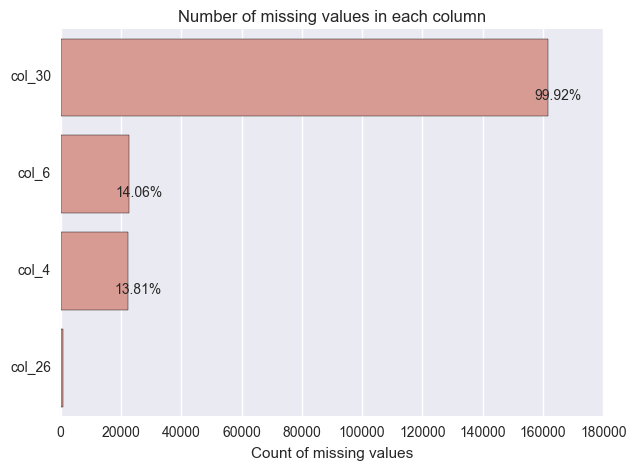

In [64]:
def missing_values_count(data,fig_size=(7,5),sort_vals=True,color="salmon", saturation=.5,x_title='',y_title='',add_percent=True,add_percent_rects_coef=1.2,add_percent_threshold=0.02,rects_intercept_coef=0.02):
    
    missing_df = data.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df = missing_df.ix[missing_df['missing_count']>0]
    plt.figure(figsize=fig_size)
    if sort_vals:missing_df.sort_values(by='missing_count',ascending=False,inplace=True)
    bar=sns.barplot(x='missing_count', y='column_name', data=missing_df, color=color, saturation=saturation)
    plt.xlabel(x_title)
    plt.ylabel('')
    plt.title(y_title)
    #lenth = rect.get_width() + 
    missing_df['perc']=missing_df.missing_count/data.shape[0]
    if add_percent:
        df_rows=data.shape[0]
        height=bar.patches[0].get_height()/add_percent_rects_coef
        intercept=df_rows*rects_intercept_coef
        perc_array=list(missing_df.perc)
        for i,rect in enumerate(bar.patches):
            lenth = rect.get_width()
            perc= perc_array[i]
            if perc>add_percent_threshold:
                plt.text(lenth+intercept ,rect.get_y()+height,'{:.2%}'.format(perc),
                    #'%.2f' % (100*perc)+' %',
                    ha='center', va='bottom')
        
    return missing_df.reset_index(drop=True)
missing_df=missing_values_count(data,x_title='Count of missing values',y_title='Number of missing values in each column')
print('Number if features with skips:',missing_df.shape[0],'\nProportion:',
      '{:.2%}'.format(missing_df.shape[0]/data.shape[1]))

In [62]:
missing_df

,column_name,missing_count,perc
0,col_30,161829,0.999222
1,col_6,22776,0.140632
2,col_4,22368,0.138112
3,col_26,885,0.005464


In [54]:
data.col_4.dtype=='<M8[ns]'

True

In [56]:
data.col_6.dtype=='<M8[ns]'

True